# Projekt 6: Przewidywanie struktury drugorzędowej RNA

In [1]:
# %pip install matplotlib pandas seaborn

In [2]:
import os
import random
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


DATASET_DIR = Path("./resources/datasets")
MODELS_DIR = Path("./resources/models")
RESULTS_DIR = Path("./resources/results")

In [3]:
def split_datasets(
    path: Path, train_ratio: float = 0.7, valid_ratio: float = 0.15, test_ratio: float = 0.15
) -> None:
    random.seed(42)
    files = [f"{path}/{f}" for f in os.listdir(path) if f.endswith(".bpseq")]
    random.shuffle(files)

    total_files = len(files)
    train_count = int(total_files * train_ratio)
    valid_count = int(total_files * valid_ratio)

    train_files = files[:train_count]
    valid_files = files[train_count : train_count + valid_count]
    test_files = files[train_count + valid_count :]

    with open(f"{path}-train-bpseq.lst", "w") as f:
        f.write("\n".join(train_files))
    with open(f"{path}-valid-bpseq.lst", "w") as f:
        f.write("\n".join(valid_files))
    with open(f"{path}-test-bpseq.lst", "w") as f:
        f.write("\n".join(test_files))

    with open(f"{path}-train-fa.lst", "w") as f:
        f.write("\n".join(train_files).replace(".bpseq", ".fa"))
    with open(f"{path}-valid-fa.lst", "w") as f:
        f.write("\n".join(valid_files).replace(".bpseq", ".fa"))
    with open(f"{path}-test-fa.lst", "w") as f:
        f.write("\n".join(test_files).replace(".bpseq", ".fa"))


def datasets_sanity_check() -> None:
    lst_files = [file for file in os.listdir(DATASET_DIR) if file.endswith(".lst")]

    for file in lst_files:
        file_path = DATASET_DIR / file
        with open(file_path, "r") as f:
            lines = f.readlines()
        num_lines = len(lines)

        total_files = len(os.listdir(DATASET_DIR / file.split("-")[0])) // 2
        print(f"{file:<25} has {round(num_lines/total_files * 100)}% files ({num_lines})")

In [4]:
split_datasets(DATASET_DIR / "ArchiveII")
split_datasets(DATASET_DIR / "PDB")
datasets_sanity_check()

ArchiveII-train-fa.lst    has 70% files (2779)
PDB-train-fa.lst          has 70% files (413)
ArchiveII-test-bpseq.lst  has 15% files (596)
ArchiveII-test-fa.lst     has 15% files (596)
ArchiveII-valid-fa.lst    has 15% files (595)
PDB-valid-fa.lst          has 15% files (88)
PDB-valid-bpseq.lst       has 15% files (88)
PDB-test-bpseq.lst        has 15% files (89)
ArchiveII-train-bpseq.lst has 70% files (2779)
PDB-test-fa.lst           has 15% files (89)
ArchiveII-valid-bpseq.lst has 15% files (595)
PDB-train-bpseq.lst       has 70% files (413)


## ArchiveII Dataset

In [5]:
NUMBER_OF_EPOCHS = 1

In [6]:
DATASET_NAME = "ArchiveII"
!mxfold2 train {DATASET_DIR}/{DATASET_NAME}-train-bpseq.lst --test-input {DATASET_DIR}/{DATASET_NAME}-valid-bpseq.lst \
    --param {MODELS_DIR}/{DATASET_NAME}-model.pth --save-config {MODELS_DIR}/{DATASET_NAME}-model.conf --epoch {NUMBER_OF_EPOCHS}

100%|█████████████████| 2779/2779 [07:27<00:00,  6.20it/s, train_loss=1.391e-01]
Train Epoch: 1	Loss: 0.139070	Time: 447.986s
100%|████████████████████| 595/595 [01:58<00:00,  5.02it/s, test_loss=1.363e-01]
Test Epoch: 1	Loss: 0.136262	Time: 118.471s


In [7]:
DATASET_NAME = "ArchiveII"
!mxfold2 predict {DATASET_DIR}/{DATASET_NAME}-test-bpseq.lst --param {MODELS_DIR}/{DATASET_NAME}-model.pth \
    --bpseq {RESULTS_DIR}/{DATASET_NAME} --result {RESULTS_DIR}/{DATASET_NAME}-results.csv

## PDB Dataset

In [8]:
DATASET_NAME = "PDB"
!mxfold2 train {DATASET_DIR}/{DATASET_NAME}-train-bpseq.lst --test-input {DATASET_DIR}/{DATASET_NAME}-valid-bpseq.lst \
    --param {MODELS_DIR}/{DATASET_NAME}-model.pth --save-config {MODELS_DIR}/{DATASET_NAME}-model.conf --epoch {NUMBER_OF_EPOCHS}

100%|███████████████████| 413/413 [08:36<00:00,  1.25s/it, train_loss=1.378e-01]
Train Epoch: 1	Loss: 0.137833	Time: 516.305s
100%|██████████████████████| 88/88 [03:23<00:00,  2.31s/it, test_loss=1.439e-01]
Test Epoch: 1	Loss: 0.143882	Time: 203.428s


In [9]:
DATASET_NAME = "PDB"
!mxfold2 predict {DATASET_DIR}/{DATASET_NAME}-test-bpseq.lst --param {MODELS_DIR}/{DATASET_NAME}-model.pth \
    --bpseq {RESULTS_DIR}/{DATASET_NAME} --result {RESULTS_DIR}/{DATASET_NAME}-results.csv

## Transfer Learning (ArchiveII -> PDB)

In [10]:
DATASET_NAME = "PDB"
!mxfold2 train {DATASET_DIR}/{DATASET_NAME}-train-bpseq.lst --test-input {DATASET_DIR}/{DATASET_NAME}-valid-bpseq.lst --init-param {MODELS_DIR}/ArchiveII-model.pth \
    --param {MODELS_DIR}/TransferLearning-model.pth --save-config {MODELS_DIR}/TransferLearning-model.conf --epoch {NUMBER_OF_EPOCHS}

100%|███████████████████| 413/413 [08:58<00:00,  1.30s/it, train_loss=1.320e-01]
Train Epoch: 1	Loss: 0.131959	Time: 538.617s
100%|██████████████████████| 88/88 [03:25<00:00,  2.34s/it, test_loss=1.347e-01]
Test Epoch: 1	Loss: 0.134736	Time: 205.834s


In [15]:
DATASET_NAME = "PDB"
!mxfold2 predict {DATASET_DIR}/{DATASET_NAME}-test-bpseq.lst --param {MODELS_DIR}/TransferLearning-model.pth \
    --bpseq {RESULTS_DIR}/TransferLearning --result {RESULTS_DIR}/TransferLearning-results.csv

## Results

In [16]:
columns: list[str] = [
    "filename",
    "sequence_length",
    "elapsed_time",
    "sc",
    "tp",
    "tn",
    "fp",
    "fn",
    "sen",
    "ppv",
    "fval",
    "mcc",
]

results = pd.read_csv(RESULTS_DIR / "ArchiveII-results.csv", header=None, names=columns)
results.head()

,filename,sequence_length,elapsed_time,sc,tp,tn,fp,fn,sen,ppv,fval,mcc
0,resources/datasets/ArchiveII/tRNA_tdbR00000133...,74,0.002752,2.904319,12,2670,9,10,0.545455,0.571429,0.558140,0.554748
1,resources/datasets/ArchiveII/tRNA_tdbR00000184...,76,0.001994,1.462533,6,2822,8,14,0.300000,0.428571,0.352941,0.354814
2,resources/datasets/ArchiveII/RNaseP_C.trachoma...,408,0.161475,12.278578,79,82867,30,52,0.603053,0.724771,0.658333,0.660632
3,resources/datasets/ArchiveII/5s_Graphiola-phoe...,118,0.007504,4.313518,33,6866,2,2,0.942857,0.942857,0.942857,0.942566
4,resources/datasets/ArchiveII/srp_Clos.acet._AE...,262,0.062408,8.972773,66,34089,13,23,0.741573,0.835443,0.785714,0.786590


In [17]:
def calculate_metrics(results: pd.DataFrame) -> pd.DataFrame:
    """Calculate the metrics for the given results: INF, PPV, TPR, TNR."""
    tp_sum, tn_sum, fp_sum, fn_sum = results[["tp", "tn", "fp", "fn"]].sum()
    ppv = tp_sum / (tp_sum + fp_sum)
    tpr = tp_sum / (tp_sum + fn_sum)
    inf = (ppv * tpr) ** 0.5
    tnr = tn_sum / (tn_sum + fp_sum)
    return inf, ppv, tpr, tnr


def plot_metrics(datasets: tuple[str]) -> None:
    """Plot the metrics for the given results."""
    metrics = defaultdict(dict)
    for dataset in datasets:
        df = pd.read_csv(RESULTS_DIR / f"{dataset}-results.csv", header=None, names=columns)
        inf, ppv, tpr, tnr = calculate_metrics(df)
        metrics["inf"].update({dataset: inf})
        metrics["ppv"].update({dataset: ppv})
        metrics["tpr"].update({dataset: tpr})
        metrics["tnr"].update({dataset: tnr})

    colors = sns.color_palette("magma", 3)
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
    ax1, ax2, ax3, ax4 = axs.flatten()

    ax1.set_title("INF")
    ax1.bar(metrics["inf"].keys(), metrics["inf"].values(), color=colors, label="INF")
    ax1.grid(axis="y", linestyle="--", alpha=0.25)
    ax1.set_xlabel("dataset")
    ax1.set_ylabel("score")

    ax2.set_title("PPV")
    ax2.bar(metrics["ppv"].keys(), metrics["ppv"].values(), color=colors, label="PPV")
    ax2.grid(axis="y", linestyle="--", alpha=0.25)
    ax2.set_xlabel("dataset")
    ax2.set_ylabel("score")

    ax3.set_title("TPR")
    ax3.bar(metrics["tpr"].keys(), metrics["tpr"].values(), color=colors, label="TPR")
    ax3.grid(axis="y", linestyle="--", alpha=0.25)
    ax3.set_xlabel("dataset")
    ax3.set_ylabel("score")

    ax4.set_title("TNR")
    ax4.bar(metrics["tnr"].keys(), metrics["tnr"].values(), color=colors, label="TNR")
    ax4.grid(axis="y", linestyle="--", alpha=0.25)
    ax4.set_xlabel("dataset")
    ax3.set_ylabel("score")

    fig.savefig(f"./resources/figures/results.png")

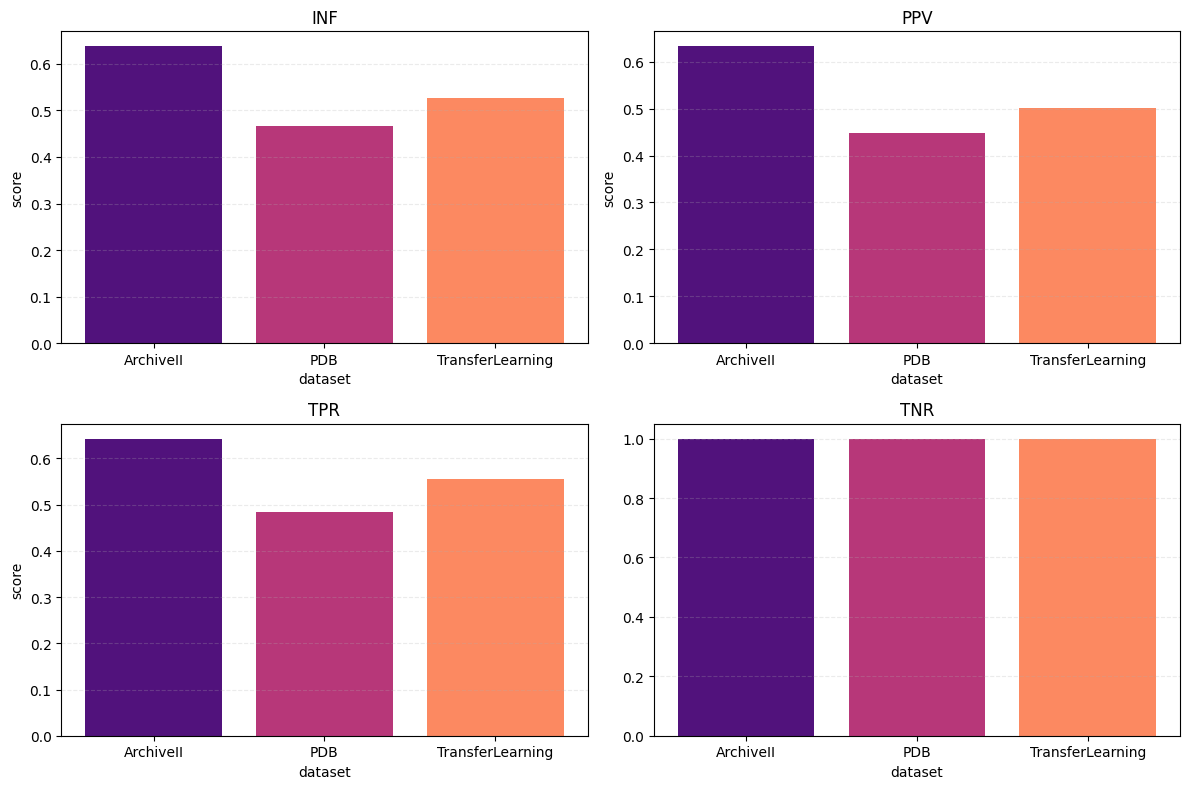

In [18]:
datasets = ("ArchiveII", "PDB", "TransferLearning")

plot_metrics(datasets)